<a href="https://colab.research.google.com/github/angelamejia804/TimeSeries/blob/main/Recepcion_Sarimax_3_2021_2022_Exogen_Var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pylab as pl
import warnings
import itertools
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from matplotlib.colors import Normalize
from time import time
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


mpl.rcParams['figure.figsize'] = (11, 4)
mpl.rcParams['axes.grid'] = False

import statsmodels.api as sm

plt.style.use('fivethirtyeight')

BASE DE DATOS DE RECEPCIÓN

Cargamos el archivo que se dejo preparado en el notebook
https://github.com/angelamejia804/TimeSeries/blob/main/Preparacion_TimeSeries_Recepcion_2_1.ipynb



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving df_recepcion_traint.csv to df_recepcion_traint.csv


In [ ]:
df_r = pd.read_csv("df_recepcion_traint.csv", delimiter=';')

In [ ]:
df_r['Semana'] = df_r['Semana'].apply(str)  #fecha = pd.to_datetime(semana_str + '1', format='%Y%U%w')
#df['fecha'] = df['semana'].apply(lambda x: pd.to_datetime(x + '1', format='%Y%U%w'))

In [ ]:
df_r

,Semana,Tallos
0,2020-W01,91939
1,2020-W02,200892
2,2020-W03,676003
3,2020-W04,1288302
4,2020-W05,507192
...,...,...
151,2022-W48,311432
152,2022-W49,270706
153,2022-W50,257158
154,2022-W51,280126


In [ ]:
df_r.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Semana,156,156,2020-W01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tallos,156.0,NaN,NaN,NaN,282305.275641,178650.036641,72136.0,176563.5,237865.0,306604.75,1288302.0


In [ ]:
df_r.head()

,Semana,Tallos
0,2020-W01,91939
1,2020-W02,200892
2,2020-W03,676003
3,2020-W04,1288302
4,2020-W05,507192


Creamos un indice por semana que va ser usada como columna de agrupación y analisis, ademas se unira a los demas DF por este mismo atributo

In [ ]:
df_recepcion = df_r.set_index('Semana')

In [ ]:
df_recepcion = df_recepcion['2021-W01':]

In [ ]:
df_recepcion=df_recepcion.groupby('Semana').sum() # promedio semanal

In [ ]:
df_recepcion_=df_recepcion.loc['2020-W01':] #desde el df original para el rango de tiempo seleccionado

In [ ]:
df_recepcion_prueba=df_recepcion_.loc['2020-W01':'2021-W53'] #desde el df original para el rango de tiempo seleccionado
df_recepcion_prueba.head()

,Tallos
Semana,
2021-W01,389471
2021-W02,198685
2021-W03,423367
2021-W04,930583
2021-W05,845326


In [ ]:
df_recepcion_test=df_recepcion.loc['2022-W01':'2022-W53'] #dejamos el 2023 para probar el modelo
df_recepcion_test.head()

,Tallos
Semana,
2022-W01,208288
2022-W02,447260
2022-W03,772645
2022-W04,809965
2022-W05,504756


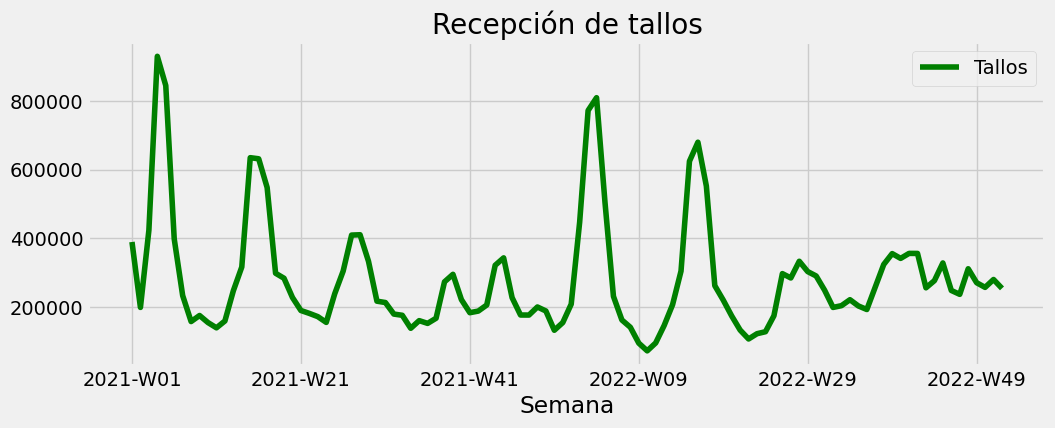

In [ ]:
df_recepcion.plot(kind='line',y='Tallos',color='green')
plt.title("Recepción de tallos")
plt.show()


In [ ]:
df_recepcion

,Tallos
Semana,
2021-W01,389471
2021-W02,198685
2021-W03,423367
2021-W04,930583
2021-W05,845326
...,...
2022-W48,311432
2022-W49,270706
2022-W50,257158


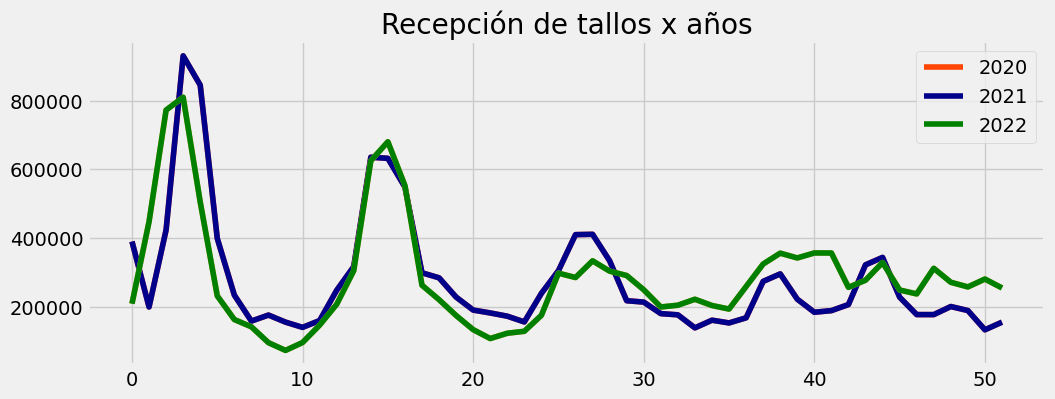

In [ ]:
df_rec_2020 = df_recepcion.loc['2020-W01':'2020-W53']
plt.plot(df_rec_2020.values)
plt.plot(df_rec_2020.values, color='orangered', label='2020')

df_rec_2021 = df_recepcion.loc['2021-W01':'2021-W53']
plt.plot(df_rec_2021.values)
plt.plot(df_rec_2021.values, color='darkblue',label='2021' )


df_rec_2022 = df_recepcion.loc['2022-W01':'2022-W53']
plt.plot(df_rec_2022.values)
plt.plot(df_rec_2022.values, color='green' ,label='2022')

#df_rec_2023 = df_recepcion.loc['2023-W01':'2023-W53']
#plt.plot(df_rec_2023.values)
#plt.plot(df_rec_2023.values, color='salmon',label='2023')

plt.title("Recepción de tallos x años")
plt.legend()

--------------------- ----------------------- ---------------------              ----------------------------------------- ---------

SARIMAX

Los modelos autorregresivos operan bajo la premisa de que los valores pasados tienen un efecto sobre los valores actuales. Los modelos AR se usan comúnmente para analizar la naturaleza, la economía y otros procesos que varían en el tiempo. Mientras se mantenga la suposición, podemos construir un modelo de regresión lineal que intente predecir el valor de una variable dependiente hoy, dados los valores que tenía en días anteriores.

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-movingc-average-model-arima-c1005347b0d7


 SARIMAX incluye un modelo exógeno que ARIMA no tiene. SARIMAX es más adecuado para modelos de series de tiempo que incluyen variables externas y tiene en cuenta la estacionalidad de los datos. ARIMA se utiliza principalmente para el análisis de la tendencia y la estacionalidad de los datos de la serie temporal.

In [ ]:
#recepcion = df_recepcion.loc['202001':'202253'] #unicamente los años competos

In [ ]:
#recepcion

In [ ]:
df_recepcion_prueba=df_recepcion_.loc['2020-W01':'2021-W53'] #desde el df original para el rango de tiempo seleccionado
df_recepcion_prueba.head()

,Tallos
Semana,
2021-W01,389471
2021-W02,198685
2021-W03,423367
2021-W04,930583
2021-W05,845326


In [ ]:
df_recepcion_test=df_recepcion.loc['2022-W01':'2022-W53'] #dejamos el 2023 para probar el modelo
df_recepcion_test.head()

,Tallos
Semana,
2022-W01,208288
2022-W02,447260
2022-W03,772645
2022-W04,809965
2022-W05,504756


In [ ]:
#y=df_recepcion_prueba

In [ ]:
#y

Probamos definiendo los parametros a traves del calculo AIC, con el DF completo (2020- 2022)

In [ ]:
y=df_recepcion

In [ ]:
y # los datos de la serie comppleta 2020-2022

,Tallos
Semana,
2021-W01,389471
2021-W02,198685
2021-W03,423367
2021-W04,930583
2021-W05,845326
...,...
2022-W48,311432
2022-W49,270706
2022-W50,257158


Definición deparametros de Sarimax con criterio AIC

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [ ]:
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [ ]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [ ]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 0, 0, 52)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

#https://es.linux-console.net/?p=5324#gsc.tab=0

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:2909.3099355255517
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:1343.926681002224
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:1342.2510575044116
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:1356.8903029440555
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:1345.9259231918625
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:4.0
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:2796.6690293282927
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:1355.4900847923218
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:1263.3057579124813
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:1411.1545451202414
ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:1356.5622406444502
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:6.0
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:2677.5638930546247
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:1285.8163141492207
ARIMA(0, 1, 0)x(0, 1, 0, 52)52 - AIC:1292.2475032950542
ARIMA(0, 1, 0)x(0, 1, 1, 52



*   Vamos a probar con estos resultados




In [ ]:
def modelo(p=1,d=0,q=1,s=52, y=y):
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=(p,d, q),
                                seasonal_order=(p, d,q, s),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])

In [ ]:
df_recepcion

,Tallos
Semana,
2021-W01,389471
2021-W02,198685
2021-W03,423367
2021-W04,930583
2021-W05,845326
...,...
2022-W48,311432
2022-W49,270706
2022-W50,257158


In [ ]:
y=df_recepcion.loc['2020-W01':'2022-W53']





1.   RIMA(0, 1, 1)x(0, 0, 1, 52)52 - AIC:1243.569194517927
2.   ARIMA(0, 1, 1)x(1, 0, 1, 52)52 - AIC:1243.0187123273436
3.   ARIMA(1, 1, 1)x(1, 0, 1, 52)52 - AIC:1244.3349252410997






In [ ]:
#y

Sarimax con los parametros definidos por AIC y con datos de 2021- 2022

       order=(2,1, 3),
                                seasonal_order=(2, 0, 3, 52), esta es la mejor combinación

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2,1, 3),
                                seasonal_order=(2, 0, 3, 52),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])
#

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3001      0.152     -1.970      0.049      -0.599      -0.002
ar.L2          0.0254      0.188      0.135      0.893      -0.343       0.394
ma.L1          0.4918   2574.148      0.000      1.000   -5044.746    5045.730
ma.L2         -0.6971   3840.259     -0.000      1.000   -7527.466    7526.072
ma.L3         -0.7948   2045.858     -0.000      1.000   -4010.602    4009.013
ar.S.L52       0.3633   1.41e+04   2.58e-05      1.000   -2.77e+04    2.77e+04
ar.S.L104     -0.0380   7184.769  -5.29e-06      1.000   -1.41e+04    1.41e+04
ma.S.L52       0.4356   1.41e+04   3.08e-05      1.000   -2.77e+04    2.77e+04
ma.S.L104     -0.0801   7301.175   -1.1e-05      1.000   -1.43e+04    1.43e+04
ma.S.L156      0.0334   4701.558   7.11e-06      1.000   -9214.851    9214.918
sigma2      5.336e+09   1.75e-06   3.06e+15      0.0

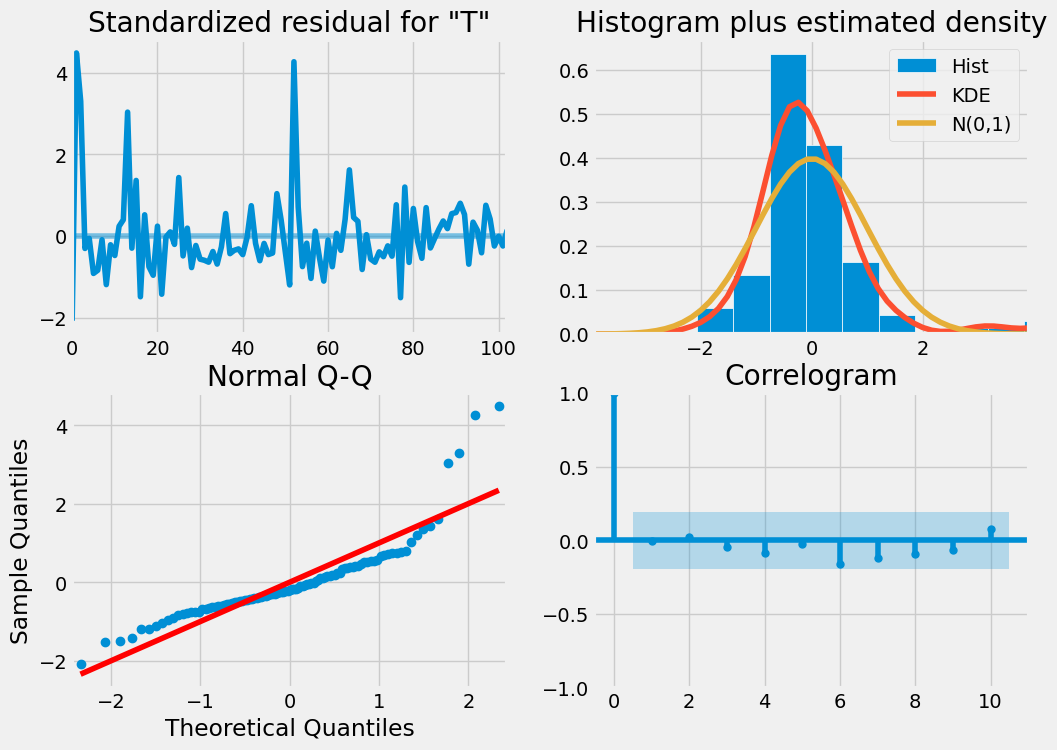

In [ ]:
results.plot_diagnostics(figsize=(11, 8))
plt.show()

In [ ]:
#pred = results.get_prediction(start=pd.to_datetime('202101'), dynamic=False)
pred=results.get_prediction(start_week='2021-W52', dynamic =False)#, ) #  los pronosticos comienzan en enero del 2021
pred_ci = pred.conf_int() #calcula el intevalo de confianza

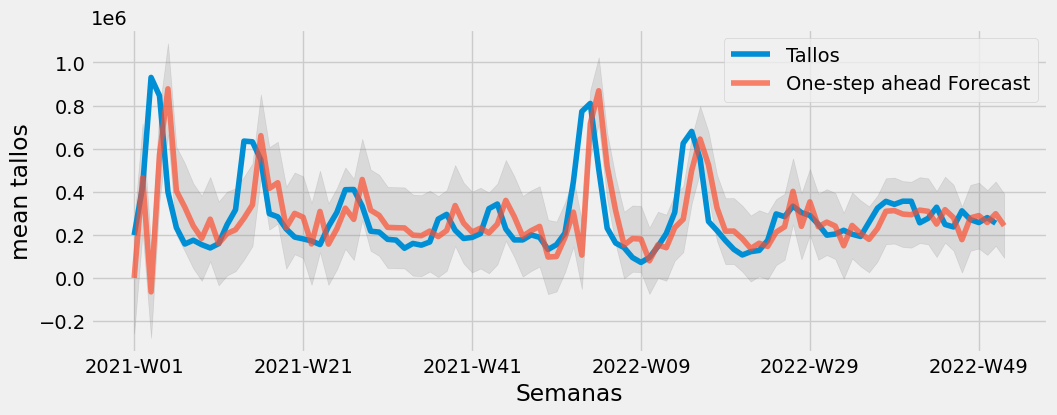

In [ ]:
#ax = y['202101':].plot(label='observed') #datos desde 202001
ax =y.loc['2021-W02':].plot(label='datos originales') #datos desde 202001

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)

ax.set_xlabel('Semanas')
ax.set_ylabel('mean tallos')
plt.legend()
plt.show()

In [ ]:
pred.predicted_mean# pronosticos para un paso con datos del 2020

Semana
2021-W01         0.000000
2021-W02    464490.960525
2021-W03    -64442.759420
2021-W04    571362.666440
2021-W05    877747.899510
                ...      
2022-W48    278778.073625
2022-W49    289454.917068
2022-W50    257354.884913
2022-W51    298360.809735
2022-W52    242633.682742
Name: predicted_mean, Length: 104, dtype: float64

MSE de la predicción de un paso


In [ ]:
 y_forecasted=pred.predicted_mean

In [ ]:
y_forecasted.to_csv('ForecastArima.csv',sep= ";", header=True, index=True)

In [ ]:
y_truth = y['2021-W02':]
#y_truth=y['2020-W03':]vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
#ax =df_recepcion.loc['202001':].plot(label='datos originales') #datos desde 202001

In [ ]:
y_truth

,Tallos
Semana,
2021-W02,198685
2021-W03,423367
2021-W04,930583
2021-W05,845326
2021-W06,398537
...,...
2022-W48,311432
2022-W49,270706
2022-W50,257158


In [ ]:
y_forecasted=y_forecasted['2021-W02':]

In [ ]:
y_forecasted

Semana
2021-W02    464490.960525
2021-W03    -64442.759420
2021-W04    571362.666440
2021-W05    877747.899510
2021-W06    404230.030530
                ...      
2022-W48    278778.073625
2022-W49    289454.917068
2022-W50    257354.884913
2022-W51    298360.809735
2022-W52    242633.682742
Name: predicted_mean, Length: 103, dtype: float64

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
score = r2_score(y_truth, y_forecasted)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)

In [ ]:
print('R2 {}'.format(round(score, 8)))
print('Mape is {}'.format(round(mape, 10))) #distancia

R2 0.65957852
Mape is 0.2343573942


pron0sticos dinamicos

In [ ]:
start_index = y.index.min() #df_recepcion_test.index.min()
end_index = y.index.max()#df_recepcion_test.index.max()

In [ ]:
start_index

'2021-W01'

In [ ]:
end_index

'2022-W52'

In [ ]:
# hacer pronósticos dinámicos
#start_date = '2022-01-01'
start_week = '2021-W52' #arranca el pronostico en esta semana
end_w= '2022-W52'
dynamic_periods = 10
pred_dynamic = results.get_prediction(start=start_week, end= end_w, dynamic=True, dynamic_periods=dynamic_periods, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

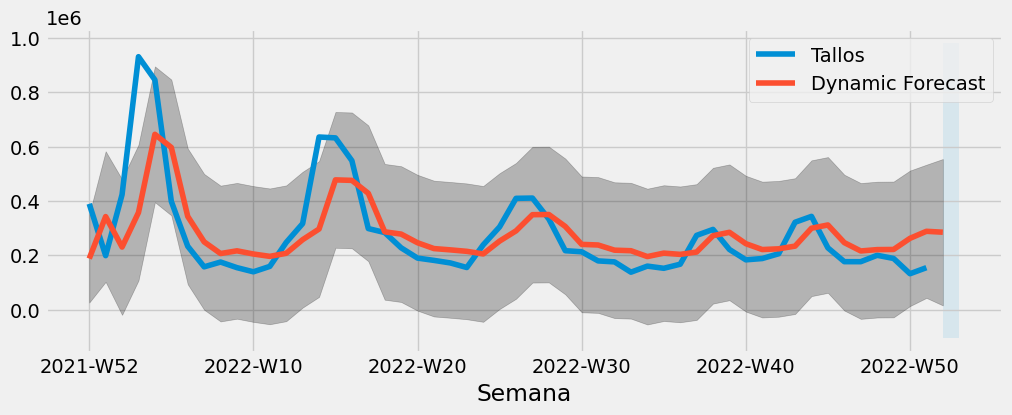

In [ ]:
#ax =df_recepcion_prueba.loc['2021-W01':'2022-W52'].plot(label='datos originales') #datos desde 202001
ax =y.loc['2021-W01':'2021-W52'].plot(label='datos originales') #datos desde 202001

pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
#start_week = '2020-W01'
#end_week = y.index.max().strftime('%Y-W%U')


ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)



ax.fill_betweenx(ax.get_ylim(), '2021-W01', y.index[-1], alpha=.1, zorder=-1)


#ax.set_xlabel('Semanas')
#ax.set_ylabel('tallos')

plt.legend()
plt.show()

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean

In [ ]:
y_forecasted

Semana
2021-W52    187898.215770
2022-W01    342484.486067
2022-W02    230281.262642
2022-W03    357262.039241
2022-W04    645093.823408
2022-W05    596693.554554
2022-W06    343205.286633
2022-W07    249450.660576
2022-W08    206505.506454
2022-W09    216467.028414
2022-W10    204767.894819
2022-W11    196111.360363
2022-W12    207401.616929
2022-W13    257424.390024
2022-W14    296706.731120
2022-W15    477447.469703
2022-W16    475614.842851
2022-W17    428104.405466
2022-W18    286351.534940
2022-W19    278059.889294
2022-W20    246173.876414
2022-W21    224729.867494
2022-W22    219951.419470
2022-W23    214598.786049
2022-W24    205083.875888
2022-W25    252331.617614
2022-W26    289895.370874
2022-W27    349446.680089
2022-W28    350008.383204
2022-W29    306138.235973
2022-W30    240172.731284
2022-W31    237895.847675
2022-W32    218847.304506
2022-W33    216833.115006
2022-W34    195299.464881
2022-W35    207993.375906
2022-W36    203432.832460
2022-W37    211929.214788
2022-

In [ ]:
y_forecasted=y_forecasted['2020-W52':]

In [ ]:
y_forecasted.to_csv('ForecastArima_Dynamic.csv',sep= ";", header=True, index=True)

In [ ]:
y_forecasted

Semana
2021-W52    187898.215770
2022-W01    342484.486067
2022-W02    230281.262642
2022-W03    357262.039241
2022-W04    645093.823408
2022-W05    596693.554554
2022-W06    343205.286633
2022-W07    249450.660576
2022-W08    206505.506454
2022-W09    216467.028414
2022-W10    204767.894819
2022-W11    196111.360363
2022-W12    207401.616929
2022-W13    257424.390024
2022-W14    296706.731120
2022-W15    477447.469703
2022-W16    475614.842851
2022-W17    428104.405466
2022-W18    286351.534940
2022-W19    278059.889294
2022-W20    246173.876414
2022-W21    224729.867494
2022-W22    219951.419470
2022-W23    214598.786049
2022-W24    205083.875888
2022-W25    252331.617614
2022-W26    289895.370874
2022-W27    349446.680089
2022-W28    350008.383204
2022-W29    306138.235973
2022-W30    240172.731284
2022-W31    237895.847675
2022-W32    218847.304506
2022-W33    216833.115006
2022-W34    195299.464881
2022-W35    207993.375906
2022-W36    203432.832460
2022-W37    211929.214788
2022-

In [ ]:
y_truth = y['2021-W52':]

In [ ]:
y_truth

,Tallos
Semana,
2021-W52,154465
2022-W01,208288
2022-W02,447260
2022-W03,772645
2022-W04,809965
2022-W05,504756
2022-W06,231055
2022-W07,162127
2022-W08,140892


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
score = r2_score(y_truth, y_forecasted)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)

In [ ]:
print('R2 {}'.format(round(score, 8)))
print('Mape is {}'.format(round(mape, 10))) #distancia

R2 0.58519118
Mape is 0.3238205052


Predicción de 30 pasos adelante a

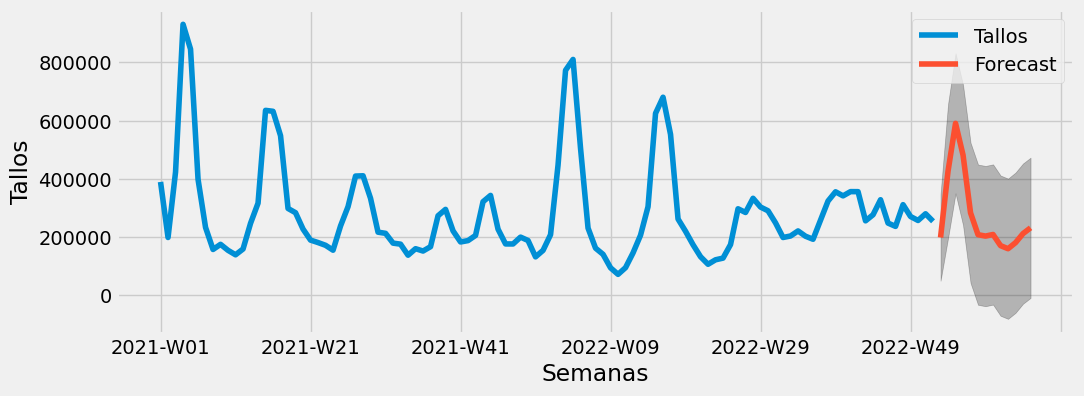

In [ ]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=13)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
#Podemos usar la salida de este código para trazar la serie temporal y los pronósticos de sus valores futuros.

#ax = y.plot(label='observed', figsize=(12, 7))
#df_r
ax =y.plot(label='datos originales') #datos desde 202001
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Semanas')
ax.set_ylabel('Tallos')

plt.legend()
plt.show()

In [ ]:
 y_forecasted_pred_uc=pred_uc.predicted_mean

In [ ]:
y_forecasted_pred_uc

104    198586.480455
105    426545.432030
106    590703.893039
107    481690.981113
108    283328.441828
109    208277.698439
110    203560.210795
111    208997.911109
112    170748.267812
113    160129.272507
114    180950.759595
115    212137.496234
116    231914.722985
Name: predicted_mean, dtype: float64

In [ ]:
#y_forecasted_pred_uc.to_csv('ForecastArima_50_Sep_202252_(2_0_3_52.csv',sep= ";", header=True, index=True)

probemos con variables exogenas

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving df_gd_t.csv to df_gd_t.csv


In [ ]:
exog_vars = pd.read_csv("df_gd_t.csv", delimiter=';')

In [ ]:
exog_vars

,Unnamed: 0,Semana,mean,std,min,25%,50%,75%,max,Grados_dia,temporada
0,0,2020-W01,9.783494,0.247887,9.61,9.628154,9.628154,9.850,10.29,68.484461,False
1,1,2020-W02,10.098571,0.636014,9.33,9.535000,10.260000,10.545,10.94,70.690000,False
2,2,2020-W03,11.054286,0.668801,10.25,10.505000,11.050000,11.610,11.85,77.380000,True
3,3,2020-W04,10.660000,0.848999,9.41,10.300000,10.540000,11.115,11.84,74.620000,True
4,4,2020-W05,9.631429,0.864551,8.08,9.290000,9.860000,10.060,10.78,67.420000,True
...,...,...,...,...,...,...,...,...,...,...,...
152,152,2022-W48,9.870000,0.430310,9.21,9.610000,9.790000,10.265,10.34,69.090000,False
153,153,2022-W49,9.345714,0.507243,8.71,8.995000,9.320000,9.625,10.15,65.420000,False
154,154,2022-W50,8.977143,0.416122,8.35,8.730000,9.020000,9.230,9.55,62.840000,False
155,155,2022-W51,9.565714,0.484591,8.95,9.225000,9.500000,9.945,10.17,66.960000,False


In [ ]:
exog_vars = exog_vars.set_index('Semana')

In [ ]:
exog_vars_1=exog_vars['temporada']

In [ ]:
exog_vars_1=exog_vars_1.loc['2021-W01':]

In [ ]:
mod2 = sm.tsa.statespace.SARIMAX(y, order=(2,1,3), seasonal_order=(2, 0, 3, 52), exog_v=exog_vars_1)  # con variable exogena de marca de temporada (bandera)
results = mod2.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3006      0.152     -1.975      0.048      -0.599      -0.002
ar.L2          0.0254      0.181      0.141      0.888      -0.329       0.379
ma.L1          0.4929      2.613      0.189      0.850      -4.628       5.614
ma.L2         -0.6966      3.901     -0.179      0.858      -8.343       6.950
ma.L3         -0.7949      2.087     -0.381      0.703      -4.886       3.296
ar.S.L52       0.3702   1.55e+04   2.39e-05      1.000   -3.04e+04    3.04e+04
ar.S.L104      0.0446   8906.836   5.01e-06      1.000   -1.75e+04    1.75e+04
ma.S.L52       0.4292   1.55e+04   2.77e-05      1.000   -3.04e+04    3.04e+04
ma.S.L104     -0.1699   8236.793  -2.06e-05      1.000   -1.61e+04    1.61e+04
ma.S.L156     -0.0348   5637.321  -6.18e-06      1.000    -1.1e+04     1.1e+04
sigma2      5.336e+09   2.23e-06   2.39e+15      0.0

In [ ]:
predictions = results.get_prediction(start_week='2021-W52', exog_vars_1='2021-W52')
pred_ci = predictions.conf_int() #calcula el intevalo de confianza

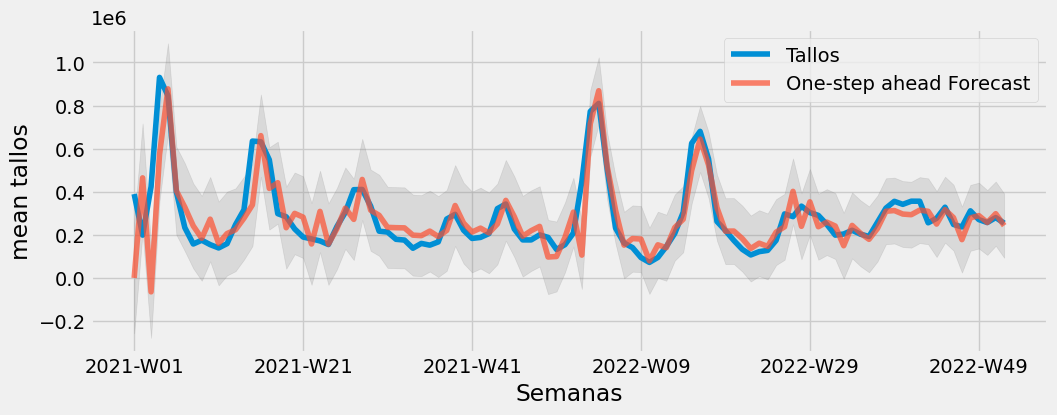

In [ ]:
#ax = y['202101':].plot(label='observed') #datos desde 202001
ax =y.loc['2021-W01':'2022-W53'].plot(label='datos originales') #datos desde 202001

predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)

ax.set_xlabel('Semanas')
ax.set_ylabel('mean tallos')
plt.legend()
plt.show()

In [ ]:
 y_forecasted=pred.predicted_mean

In [ ]:
y_forecasted

Semana
2021-W01         0.000000
2021-W02    464490.960525
2021-W03    -64442.759420
2021-W04    571362.666440
2021-W05    877747.899510
                ...      
2022-W48    278778.073625
2022-W49    289454.917068
2022-W50    257354.884913
2022-W51    298360.809735
2022-W52    242633.682742
Name: predicted_mean, Length: 104, dtype: float64

In [ ]:
###y_forecasted.to_csv('ForecastArima_AIC_EXOGEN.csv',sep= ";", header=True, index=True)

In [ ]:
y_truth = y['2021-W01':]

In [ ]:
y_forecasted=y_forecasted['2021-W01':]

In [ ]:
y_forecasted

Semana
2021-W01         0.000000
2021-W02    464490.960525
2021-W03    -64442.759420
2021-W04    571362.666440
2021-W05    877747.899510
                ...      
2022-W48    278778.073625
2022-W49    289454.917068
2022-W50    257354.884913
2022-W51    298360.809735
2022-W52    242633.682742
Name: predicted_mean, Length: 104, dtype: float64

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
score = r2_score(y_truth, y_forecasted)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)

In [ ]:
print('R2 {}'.format(round(score, 8)))
print('Mape is {}'.format(round(mape, 10))) #distancia

R2 0.60703588
Mape is 0.2417193424


Provemos el sarimax de un paso con las variables exogenas y los parametros del mejor modelo

In [ ]:
mod3 = sm.tsa.statespace.SARIMAX(y, order=(1,0, 2), seasonal_order=(1, 0, 3, 52), exog_v=exog_vars_1)  # con variable exogena de marca de temporada (bandera)
results = mod3.fit()
print(results.summary().tables[1])


# order=(2,1, 3),
#    seasonal_order=(2, 0, 3, 52),

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6945      0.101      6.866      0.000       0.496       0.893
ma.L1          0.8811      0.126      6.997      0.000       0.634       1.128
ma.L2          0.3435      0.120      2.863      0.004       0.108       0.579
ar.S.L52       0.6592   2724.819      0.000      1.000   -5339.887    5341.206
ma.S.L52      -0.1613   1108.349     -0.000      1.000   -2172.485    2172.162
ma.S.L104      0.0242   1.22e+04   1.99e-06      1.000   -2.39e+04    2.39e+04
ma.S.L156     -0.0048   2.85e+04  -1.67e-07      1.000   -5.59e+04    5.59e+04
sigma2       7.57e+09      0.052   1.45e+11      0.000    7.57e+09    7.57e+09


In [ ]:
predictions = results.get_prediction(start_week='2021-W01', df_gd_t='2022-W53')
pred_ci = predictions.conf_int() #calcula el intevalo de confianza

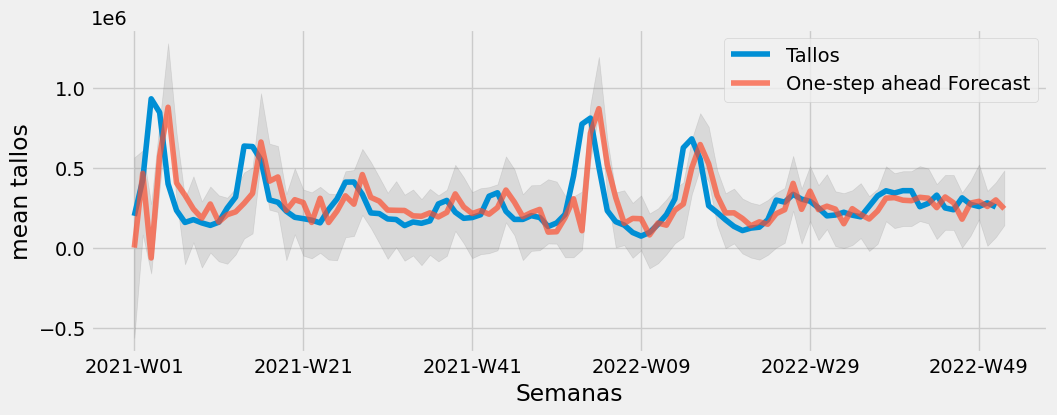

In [ ]:
#ax = y['202101':].plot(label='observed') #datos desde 202001
ax =y.loc['2021-W02':].plot(label='datos originales') #datos desde 202001

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)

ax.set_xlabel('Semanas')
ax.set_ylabel('mean tallos')
plt.legend()
plt.show()

In [ ]:
y_forecasted = predictions.predicted_mean

In [ ]:
y_forecasted=y_forecasted['2021-W02':]

In [ ]:
#y_forecasted.to_csv('ForecastArima_1_0_2_exogen.csv',sep= ";", header=True, index=True)

In [ ]:
y_truth = y['2021-W02':]

In [ ]:
y_forecasted

Semana
2021-W02    3.445806e+05
2021-W03    5.538267e+04
2021-W04    5.776630e+05
2021-W05    1.070694e+06
2021-W06    5.090739e+05
                ...     
2022-W48    2.457126e+05
2022-W49    3.486493e+05
2022-W50    1.829121e+05
2022-W51    2.373490e+05
2022-W52    3.111775e+05
Name: predicted_mean, Length: 103, dtype: float64

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
score = r2_score(y_truth, y_forecasted)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)

In [ ]:
print('R2 {}'.format(round(score, 8)))
print('Mape is {}'.format(round(mape, 10))) #distancia

R2 0.66122684
Mape is 0.2321020391


La predicción mejora un poco en esta configuración cuando usamos las variables exogenas